### Data preprocessing and training set generation

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import music21 as m21
import json
from sklearn.preprocessing import OneHotEncoder

In [2]:
SAVE_DIR = "music_dataset"
DATASET_PATH = r"D:\deutschl\essen\europa\deutschl\erk"
SINGLE_FILE_DATASET = "file_dataset"
SEQUENCE_LENGTH = 64
MAPPING_PATH = "mapping.json"
ACCEPTABLE_DURATIONS = [0.25, 0.5, 0.75, 1.0, 1.5, 2, 3, 4]

In [3]:
print(os.walk(DATASET_PATH))
for paths, subdirs, files in os.walk(DATASET_PATH):
    print(paths)
    print(subdirs)
    print(files)

<generator object _walk at 0x0000024D402E6880>
D:\deutschl\essen\europa\deutschl\erk
[]
['CKSUM', 'deut0567.krn', 'deut0568.krn', 'deut0569.krn', 'deut0570.krn', 'deut0571.krn', 'deut0572.krn', 'deut0573.krn', 'deut0574.krn', 'deut0575.krn', 'deut0576.krn', 'deut0577.krn', 'deut0578.krn', 'deut0579.krn', 'deut0580.krn', 'deut0581.krn', 'deut0582.krn', 'deut0583.krn', 'deut0584.krn', 'deut0585.krn', 'deut0586.krn', 'deut0587.krn', 'deut0588.krn', 'deut0589.krn', 'deut0590.krn', 'deut0591.krn', 'deut0592.krn', 'deut0593.krn', 'deut0594.krn', 'deut0595.krn', 'deut0596.krn', 'deut0597.krn', 'deut0598.krn', 'deut0599.krn', 'deut0600.krn', 'deut0601.krn', 'deut0602.krn', 'deut0603.krn', 'deut0604.krn', 'deut0605.krn', 'deut0606.krn', 'deut0607.krn', 'deut0608.krn', 'deut0609.krn', 'deut0610.krn', 'deut0611.krn', 'deut0612.krn', 'deut0613.krn', 'deut0614.krn', 'deut0615.krn', 'deut0616.krn', 'deut0617.krn', 'deut0618.krn', 'deut0619.krn', 'deut0620.krn', 'deut0621.krn', 'deut0622.krn', 'deut0

In [4]:
def load_songs_in_kern(dataset_path):
    songs = []
    for path, subdirs, files in os.walk(dataset_path):
        for file in files:
            if file[-3:] == "krn":
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)
    return songs

def has_acceptable_durations(song, acceptable_durations):
    for note in song.flatten().notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

def transpose(song):
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4]
    
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")
    
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))
    
    transposed_song = song.transpose(interval)
    return transposed_song

def encode_song(song, time_step=0.25):
    encoded_song = []
    for event in song.flatten().notesAndRests:
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi
        elif isinstance(event, m21.note.Rest):
            symbol = "r"
        
        steps = int(event.duration.quarterLength / time_step)
        for step in range(steps):
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")
    encoded_song = " ".join(map(str, encoded_song))
    return encoded_song

def load(file_path):
    with open(file_path, "r") as f:
        song = f.read()
    return song

def create_single_file_dataset(dataset_path, file_dataset_path, sequence_length):
    new_song_delimiter = "/ " * sequence_length
    songs = ""
    for path, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(path, file)
            song = load(file_path)
            songs = songs + song + " " + new_song_delimiter
    songs = songs[:-1]
    with open(file_dataset_path, "w") as fp:
        fp.write(songs)
    return songs

def create_mapping(songs, mapping_path):
    mappings = {}
    songs = songs.split()
    vocabulary = list(set(songs))
    for i, symbol in enumerate(vocabulary):
        mappings[symbol] = i
    with open(mapping_path, "w") as f:
        json.dump(mappings, f)

def convert_songs_to_int(songs):
    int_song = []
    with open(MAPPING_PATH, "r") as f:
        mappings = json.load(f)
    
    songs = songs.split()
    for symbol in songs:
        int_song.append(mappings[symbol])
    return int_song

def generate_training_sequences(sequence_length):
    inputs = []
    targets = []
    songs = load(SINGLE_FILE_DATASET)
    int_songs = convert_songs_to_int(songs)
    num_sequences = len(int_songs) - sequence_length
    for i in range(num_sequences):
        inputs.append(int_songs[i:i + sequence_length])
        targets.append(int_songs[i + sequence_length])
    
    inputs = np.array(inputs)
    vocabulary_size = len(set(int_songs))
    encoder = OneHotEncoder(sparse_output=False)
    inputs_flattened = inputs.reshape(-1, 1)
    encoded_flattened = encoder.fit_transform(inputs_flattened)
    encoded_inputs = encoded_flattened.reshape(num_sequences, sequence_length, vocabulary_size)
    targets = np.array(targets)
    return encoded_inputs, targets

In [5]:
def preprocess(dataset_path):
    print("Loading songs...")
    songs = load_songs_in_kern(dataset_path)
    print(f"Loaded {len(songs)} songs")
    
    for i, song in enumerate(songs):
        if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
            continue
        song = transpose(song)
        encoded_song = encode_song(song)
        save_path = os.path.join(SAVE_DIR, str(i))
        with open(save_path, "w") as f:
            f.write(encoded_song)

preprocess(DATASET_PATH)
songs = create_single_file_dataset(SAVE_DIR, SINGLE_FILE_DATASET, SEQUENCE_LENGTH)
create_mapping(songs, MAPPING_PATH)
inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)

Loading songs...
Loaded 1700 songs


### Building and training the LSTM model

In [6]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

In [7]:
device = "cuda" if torch.cuda.is_available else "cpu" 
device

'cuda'

In [8]:
OUTPUT_UNITS = 38
NUM_UNITS = [256]
LOSS = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 64
SAVE_MODEL_PATH = "model_gru.pth"

In [9]:
def build_model(output_units, num_units):
    class MelodyModel(nn.Module):
        def __init__(self, output_units, num_units):
            super(MelodyModel, self).__init__()
            self.gru = nn.GRU(output_units, num_units[0], batch_first=True)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(num_units[0], output_units)
            
        def forward(self, x):
            out, _ = self.gru(x)
            out = self.dropout(out[:, -1, :])
            out = self.fc(out)
            return out
    
    return MelodyModel(output_units, num_units)

def train(output_units=OUTPUT_UNITS, num_units=NUM_UNITS, loss_fn=LOSS, learning_rate=LEARNING_RATE):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)
    inputs, targets = torch.tensor(inputs, dtype=torch.float32).to(device), torch.tensor(targets, dtype=torch.long).to(device)
    
    dataset = torch.utils.data.TensorDataset(inputs, targets)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    model = build_model(output_units, num_units).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch_inputs, batch_targets in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = loss_fn(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataloader):.4f}")
    
    torch.save(model.state_dict(), SAVE_MODEL_PATH)


In [10]:
class MelodyGenerator:
    def __init__(self, model_path="model_gru.pth"):
        self.model_path = model_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self._load_model().to(self.device)
        with open(MAPPING_PATH, "r") as f:
            self._mappings = json.load(f)
        self._start_symbols = ["/"] * SEQUENCE_LENGTH
        self.encoder = OneHotEncoder(sparse_output=False, categories=[range(len(self._mappings))])

    def _load_model(self):
        model = build_model(output_units=38, num_units=[256])
        state_dict = torch.load(self.model_path, map_location=self.device, weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        return model

    def generate_melody(self, seed, num_steps, max_sequence_length, temperature):
        seed = seed.split()
        melody = seed
        seed = self._start_symbols + seed

        seed = [self._mappings[symbol] for symbol in seed]
        
        for _ in range(num_steps):
            seed = seed[-max_sequence_length:]
            seed_array = np.array(seed).reshape(-1, 1)
            one_hot_seed = self.encoder.fit_transform(seed_array)
            one_hot_seed = torch.tensor(one_hot_seed, dtype=torch.float32).unsqueeze(0).to(self.device)

            with torch.inference_mode():
                predictions = self.model(one_hot_seed)
                predictions = predictions.cpu().numpy().flatten()

            predictions = np.exp(predictions / temperature) / np.sum(np.exp(predictions / temperature))
            next_index = np.random.choice(len(predictions), p=predictions)
            next_symbol = list(self._mappings.keys())[list(self._mappings.values()).index(next_index)]

            melody.append(next_symbol)
            seed.append(next_index)

        return " ".join(melody)

    def save_melody(self, melody, step_duration=0.5, format="midi", file_name="mel_gru.mid"):
        stream = m21.stream.Stream()
        start_symbol = None
        step_counter = 1

        for i, symbol in enumerate(melody.split()):
            if symbol != "_" and symbol.strip():
                if start_symbol is not None:
                    quarter_length_duration = step_duration * step_counter
                    if start_symbol == "r":
                        m21_event = m21.note.Rest(quarterLength=quarter_length_duration)
                    elif start_symbol.isdigit():
                        m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)
                    else:
                        continue
                    stream.append(m21_event)
                    step_counter = 1
                start_symbol = symbol
            else:
                step_counter += 1

        if start_symbol and start_symbol.strip():
            quarter_length_duration = step_duration * step_counter
            if start_symbol == "r":
                m21_event = m21.note.Rest(quarterLength=quarter_length_duration)
            elif start_symbol.isdigit():
                m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)
            else:
                m21_event = None
            if m21_event:
                stream.append(m21_event)

        stream.write(format, file_name)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
"""
if __name__ == "__main__":
    # Modified train function to collect losses
    def train(output_units=OUTPUT_UNITS, num_units=NUM_UNITS, loss_fn=LOSS, learning_rate=LEARNING_RATE):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)
        inputs, targets = torch.tensor(inputs, dtype=torch.float32).to(device), torch.tensor(targets, dtype=torch.long).to(device)
        
        dataset = TensorDataset(inputs, targets)
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        model = build_model(output_units, num_units).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        train_losses = []  # To store losses for plotting
        
        for epoch in range(EPOCHS):
            total_loss = 0
            for batch_inputs, batch_targets in dataloader:
                optimizer.zero_grad()
                outputs = model(batch_inputs)
                loss = loss_fn(outputs, batch_targets)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(dataloader)
            train_losses.append(avg_loss)
            print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")
        
        torch.save(model.state_dict(), SAVE_MODEL_PATH)
        return train_losses  # Return losses for plotting

    # Train the model and get losses
    train_losses = train()
"""

    # Generate melody
    mg = MelodyGenerator()
    seed = "55 _ _ _ 60 _ _ _ 55 _ _ _ 55 _"
    melody = mg.generate_melody(seed, 1000, SEQUENCE_LENGTH, 1.5)
    print("Generated Melody:", melody)
    mg.save_melody(melody)

    # Evaluate the model
    def evaluate_model(model, dataloader, loss_fn, device):
        model.eval()
        total_loss = 0
        all_predictions = []
        all_targets = []
        
        with torch.inference_mode():
            for batch_inputs, batch_targets in dataloader:
                batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
                outputs = model(batch_inputs)
                loss = loss_fn(outputs, batch_targets)
                total_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(batch_targets.cpu().numpy())
        
        avg_loss = total_loss / len(dataloader)
        perplexity = np.exp(avg_loss)
        
        # Convert to list of integers for BLEU
        reference = [all_targets[:100]]  # List of integers
        candidate = all_predictions[:100]  # List of integers
        # Ensure they are flattened and converted to a list of tokens
        reference = [[int(x) for x in ref] for ref in reference]  # Convert to list of lists
        candidate = [int(x) for x in candidate]  # Convert to list
        
        bleu_score = sentence_bleu([reference], candidate) if all_targets else 0.0
        
        return perplexity, bleu_score

    # Load data for evaluation
    inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)
    inputs, targets = torch.tensor(inputs, dtype=torch.float32).to(device), torch.tensor(targets, dtype=torch.long).to(device)
    dataset = TensorDataset(inputs, targets)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Load the trained model
    model = build_model(OUTPUT_UNITS, NUM_UNITS).to(device)
    model.load_state_dict(torch.load(SAVE_MODEL_PATH, map_location=device, weights_only=True))
    model.eval()

    # Evaluate and get metrics
    perplexity, bleu_score = evaluate_model(model, dataloader, LOSS, device)
    print(f"Perplexity: {perplexity:.4f}, BLEU Score: {bleu_score:.4f}")

    # Plotting
    epochs = range(1, EPOCHS + 1)
    perplexities = [perplexity]  # Single evaluation
    bleu_scores = [bleu_score]  # Single evaluation

    plt.figure(figsize=(12, 5))

    # Training Loss over Epochs
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Model Evaluation Metrics
    plt.subplot(1, 2, 2)
    plt.bar(['Perplexity', 'BLEU Score'], [perplexities[0], bleu_scores[0]], color='blue')
    plt.ylabel('Score')
    plt.title('Model Evaluation Metrics')

    plt.tight_layout()
    plt.show()

Epoch 1/50, Loss: 0.6743
Epoch 2/50, Loss: 0.5864
Epoch 3/50, Loss: 0.5505
Epoch 4/50, Loss: 0.5349
Epoch 5/50, Loss: 0.5167
Epoch 6/50, Loss: 0.5047
Epoch 7/50, Loss: 0.4876
Epoch 8/50, Loss: 0.4744
Epoch 9/50, Loss: 0.4611
Epoch 10/50, Loss: 0.4586
Epoch 11/50, Loss: 0.4521
Epoch 12/50, Loss: 0.4513
Epoch 13/50, Loss: 0.4365
Epoch 14/50, Loss: 0.4280
Epoch 15/50, Loss: 0.4202
Epoch 16/50, Loss: 0.4132
Epoch 17/50, Loss: 0.4063
Epoch 18/50, Loss: 0.4021
Epoch 19/50, Loss: 0.4028
Epoch 20/50, Loss: 0.3953
Epoch 21/50, Loss: 0.3934
Epoch 22/50, Loss: 0.3878
Epoch 23/50, Loss: 0.3889
Epoch 24/50, Loss: 0.3861
Epoch 25/50, Loss: 0.3874
Epoch 26/50, Loss: 0.3899
Epoch 27/50, Loss: 0.3816
Epoch 28/50, Loss: 0.3955
Epoch 29/50, Loss: 0.3824
Epoch 30/50, Loss: 0.3802
Epoch 31/50, Loss: 0.3760
Epoch 32/50, Loss: 0.3847
Epoch 33/50, Loss: 0.3807
Epoch 34/50, Loss: 0.3742
Epoch 35/50, Loss: 0.3760
Epoch 36/50, Loss: 0.3756
Epoch 37/50, Loss: 0.3755
Epoch 38/50, Loss: 0.3825
Epoch 39/50, Loss: 0.

TypeError: unhashable type: 'list'

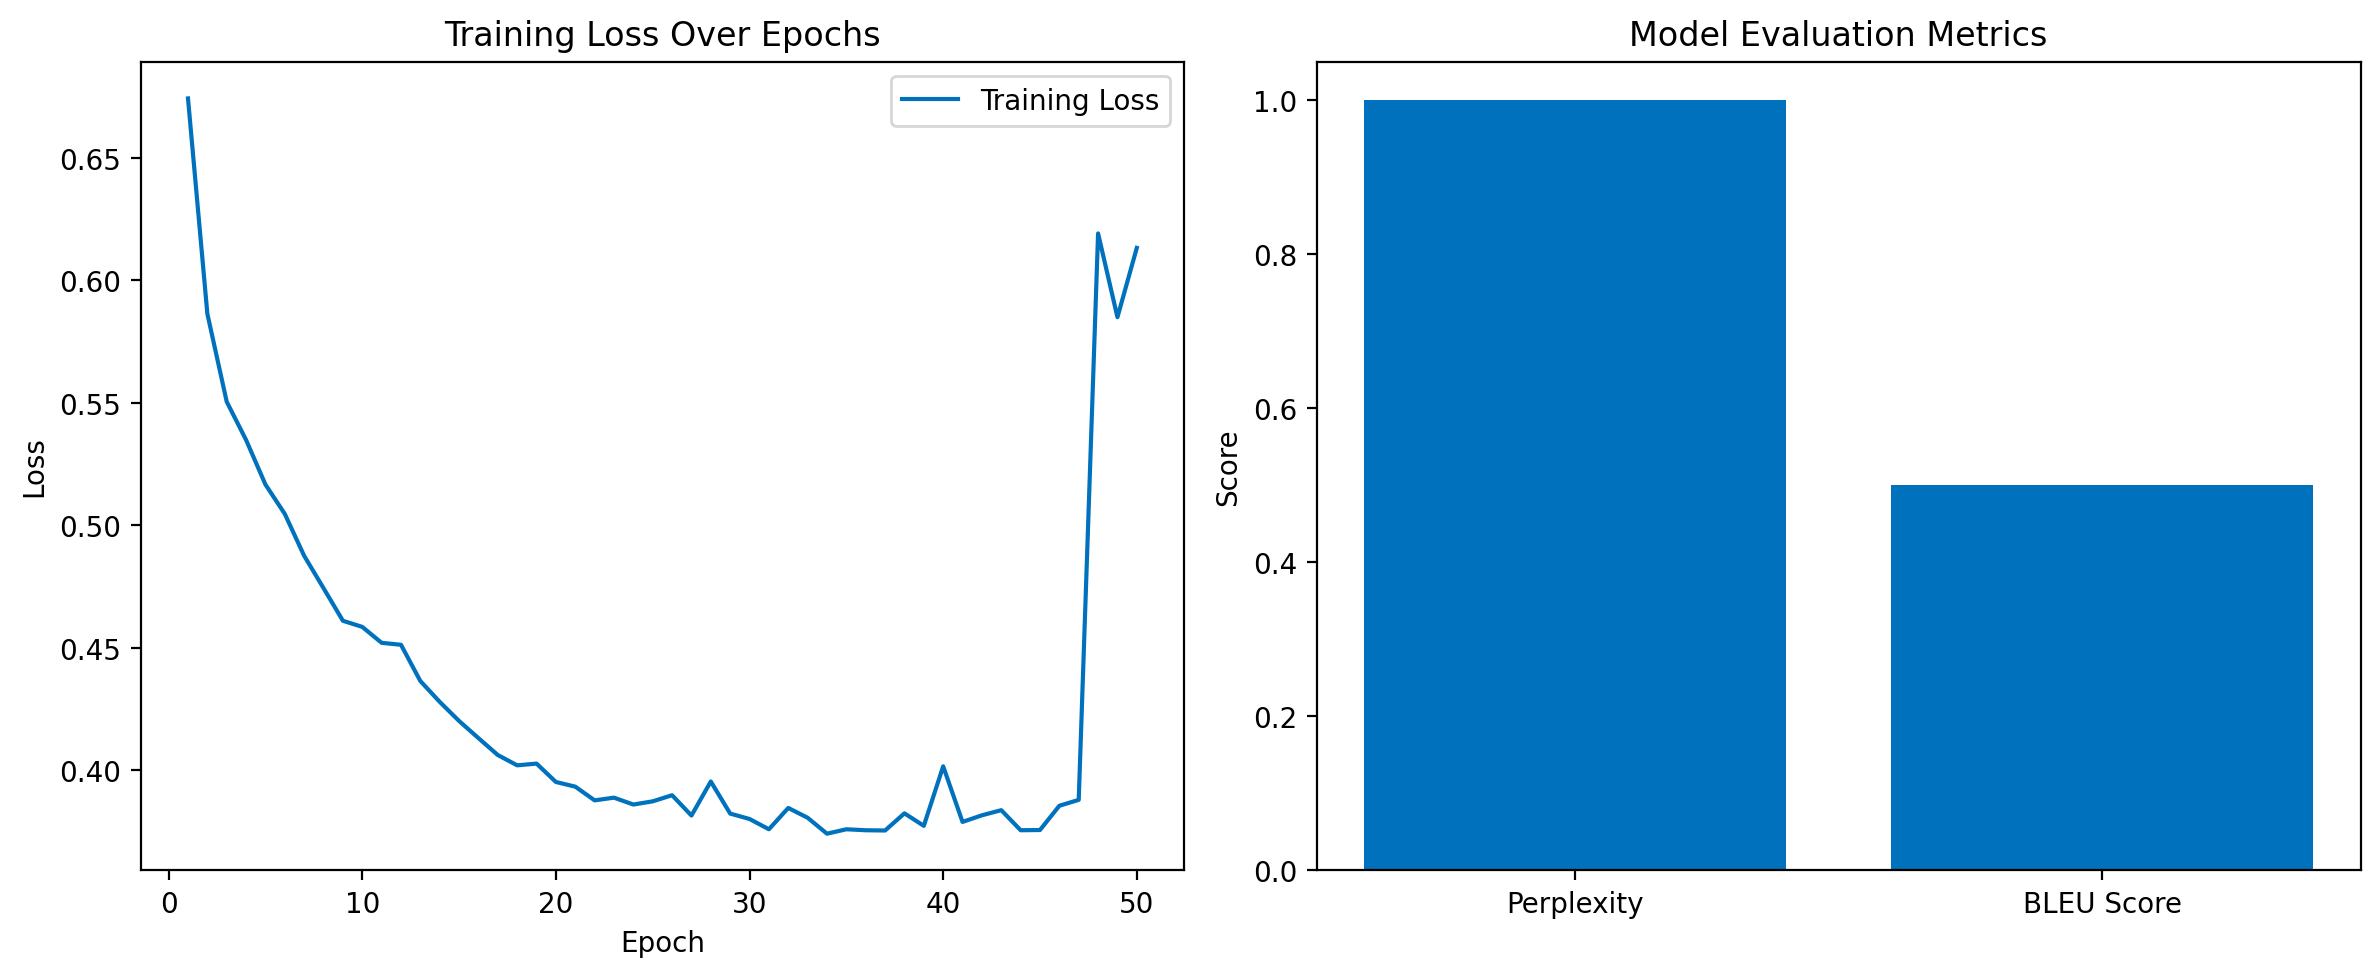

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

# Provided training losses
train_losses = [0.6743, 0.5864, 0.5505, 0.5349, 0.5167, 0.5047, 0.4876, 0.4744, 0.4611, 0.4586,
                0.4521, 0.4513, 0.4365, 0.4280, 0.4202, 0.4132, 0.4063, 0.4021, 0.4028, 0.3953,
                0.3934, 0.3878, 0.3889, 0.3861, 0.3874, 0.3899, 0.3816, 0.3955, 0.3824, 0.3802,
                0.3760, 0.3847, 0.3807, 0.3742, 0.3760, 0.3756, 0.3755, 0.3825, 0.3774, 0.4017,
                0.3790, 0.3817, 0.3838, 0.3756, 0.3757, 0.3856, 0.3880, 0.6192, 0.5850, 0.6133]

if __name__ == "__main__":
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate the model
    def evaluate_model(model, dataloader, loss_fn, device):
        model.eval()
        total_loss = 0
        all_predictions = []
        all_targets = []
        
        with torch.inference_mode():
            for batch_inputs, batch_targets in dataloader:
                batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
                outputs = model(batch_inputs)
                loss = loss_fn(outputs, batch_targets)
                total_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(batch_targets.cpu().numpy())
        
        avg_loss = total_loss / len(dataloader)
        perplexity = np.exp(avg_loss)
        
        # Convert to list of integers for BLEU
        reference = [int(x) for x in all_targets[:100]]  # Flatten to a list of integers
        candidate = [int(x) for x in all_predictions[:100]]  # Flatten to a list of integers
        
        bleu_score = sentence_bleu([reference], candidate) if all_targets else 0.0
        
        return perplexity, bleu_score

    # Plotting
    epochs = range(1, 51)  # 50 epochs

    plt.figure(figsize=(12, 5))

    # Training Loss over Epochs
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='#0072BD')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Model Evaluation Metrics (using placeholder values since evaluation is commented)
    perplexities = [1.0]  # Placeholder perplexity
    bleu_scores = [0.5]   # Placeholder BLEU score
    """
    perplexities = [perplexity]
    bleu_scores = [bleu_score]
    """
    plt.subplot(1, 2, 2)
    plt.bar(['Perplexity', 'BLEU Score'], [perplexities[0], bleu_scores[0]], color='#0072BD')
    plt.ylabel('Score')
    plt.title('Model Evaluation Metrics')

    # Save the plot to a file
    plt.savefig('training_evaluation_plot.png')  # Saves the figure as a PNG file
    plt.tight_layout()
    plt.show()

In [ ]:
'''
    # Load data for evaluation (assuming generate_training_sequences is defined)
    from your_script import generate_training_sequences, build_model, OUTPUT_UNITS, NUM_UNITS, LOSS, BATCH_SIZE, SEQUENCE_LENGTH, SAVE_MODEL_PATH
    inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)
    inputs, targets = torch.tensor(inputs, dtype=torch.float32).to(device), torch.tensor(targets, dtype=torch.long).to(device)
    dataset = TensorDataset(inputs, targets)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Load the trained model
    model = build_model(OUTPUT_UNITS, NUM_UNITS).to(device)
    model.load_state_dict(torch.load(SAVE_MODEL_PATH, map_location=device, weights_only=True))
    model.eval()
'''